In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import re
RENAMES = [
    lambda s: re.sub(r"^(pandas_)(.*)", r"\2", s),
    lambda s: re.sub(r"^(wordbatch_)(.*)", r"\2", s),
    lambda s: re.sub(r"(.*)(wordbatch.csv-)(.*)", r"\1\3", s),
    lambda s: re.sub(r"(.*)(000000)(-|$)(.*)", r"\1M\3\4", s),
    lambda s: re.sub(r"(.*)(000)(-|$)(.*)", r"\1K\3\4", s),
    lambda s: re.sub(r"(.*)1s(.*)", r"\g<1>1S\2", s)
]

def function_rename(name):
    for r in RENAMES:
        name = r(name)
    return name

df = pd.read_json(open("result.json"))
df["function"] = df.function.apply(function_rename)
#df["cluster"] = df.cluster.apply(cluster_rename)
df.function.unique()

array(['xarray-5', 'xarray-25', 'join-1-1S-1T', 'join-1-1S-1H',
       'join-1-2s-1H', 'groupby-90-1S-1H', 'groupby-90-1S-8H',
       'groupby-360-1S-1H', 'groupby-360-1S-8H', 'bag-25K-10',
       'bag-25K-50', 'bag-25K-100', 'bag-25K-200', 'tree-15',
       'numpy-50K-10', 'numpy-50K-50', 'numpy-50K-100', 'numpy-50K-200',
       'merge-10K', 'merge-15K', 'merge-25K', 'merge-50K',
       'merge_slow-5K-0.1', 'vectorizer-1M-300', 'wordbag-100K-50'],
      dtype=object)

In [4]:
def extract_nodes(data):
    name = data.cluster.split("-")
    return int(name[2][:-1])

def make_cname(row):
    name = "{}-{}-{}w".format(row.runtime, row.scheduler, row.workers)
    return name

df["benchmark"] = df["function"]
df["scheduler"] = df.cluster.apply(lambda x: x.split("-")[1])
df["nodes"] = df.apply(extract_nodes, axis=1)
df["workers"] = df["nodes"] * 24
df["runtime"] = df.cluster.apply(lambda x: x.split("-")[0])
#df["function"] = df["function"].apply(shorten_names)
df["cname"] = df.apply(make_cname, axis=1)

In [5]:
df.benchmark.unique()

array(['xarray-5', 'xarray-25', 'join-1-1S-1T', 'join-1-1S-1H',
       'join-1-2s-1H', 'groupby-90-1S-1H', 'groupby-90-1S-8H',
       'groupby-360-1S-1H', 'groupby-360-1S-8H', 'bag-25K-10',
       'bag-25K-50', 'bag-25K-100', 'bag-25K-200', 'tree-15',
       'numpy-50K-10', 'numpy-50K-50', 'numpy-50K-100', 'numpy-50K-200',
       'merge-10K', 'merge-15K', 'merge-25K', 'merge-50K',
       'merge_slow-5K-0.1', 'vectorizer-1M-300', 'wordbag-100K-50'],
      dtype=object)

In [6]:
def compute_r(f, cond):
    a = f[cond].groupby("function")["time"].mean()
    b = f[~cond].groupby("function")["time"].mean()
    ratios = b / a
    ratios = ratios.sort_values()
    return ratios

In [7]:
def get(runtime, scheduler, nodes):
    return df[(df.scheduler == scheduler) & (df.runtime == runtime) & (df.nodes == nodes)]

def comprel(runtime, scheduler, nodes):
    #baseline = get("rsds", "random", nodes).groupby("function")["time"].mean()
    baseline = get("dask", "ws", nodes).groupby("function")["time"].mean()
    vals = get(runtime, scheduler, nodes).groupby("function")["time"].mean()
    r = baseline / vals
    return r.sort_values()



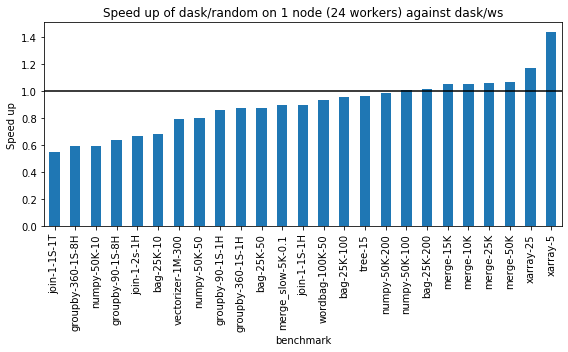

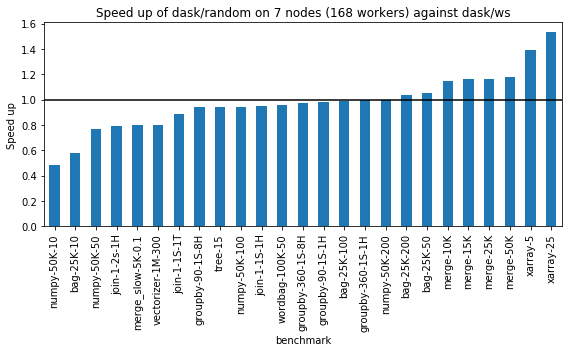

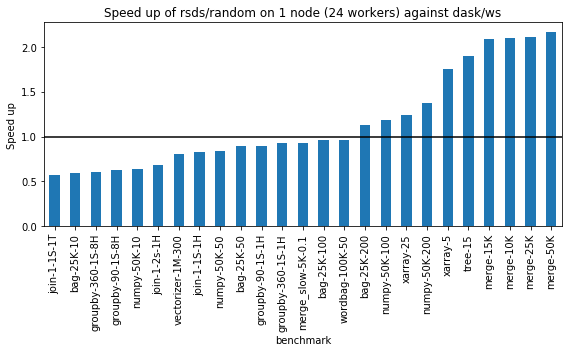

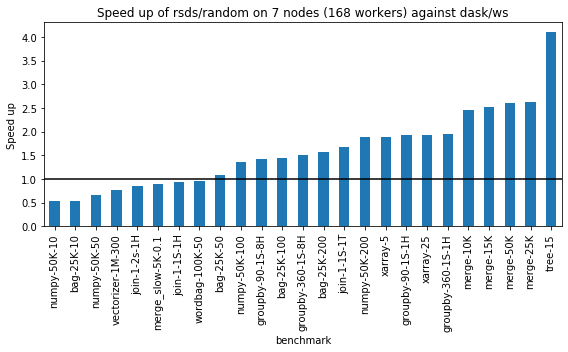

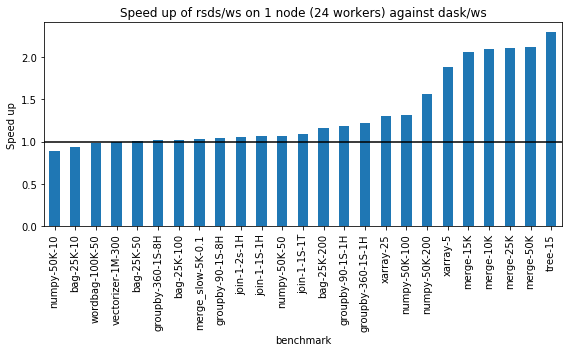

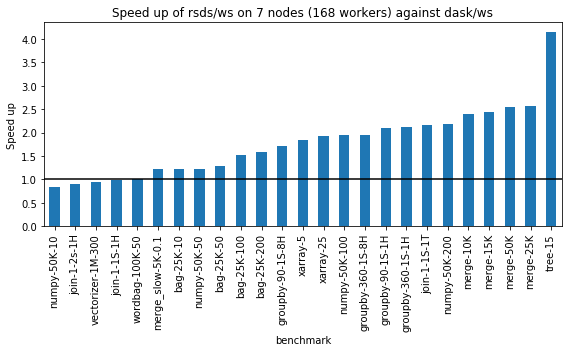

In [8]:
confs = [
    ("dask", "random"),
    ("rsds", "random"),
    ("rsds", "ws"),
]

for r, s in confs:
    for nodes in [1, 7]:
        plt.close()
        plt.figure(figsize=(8, 5))
        plt.title("Speed up of {}/{} on {} node{} ({} workers) against dask/ws".format(r, s, nodes, "" if nodes == 1 else "s", nodes * 24))
        comprel(r, s, nodes).plot.bar()                
        plt.xlabel("benchmark")        
        plt.ylabel("Speed up")        
        plt.axhline(y=1.0, color='black', linestyle='-')
        #plt.autoscale()
        plt.tight_layout()
        plt.savefig("speedup-{}-{}-{}.pdf".format(r, s, nodes), tight_layout=True)
        plt.show()

/home/spirali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/spirali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


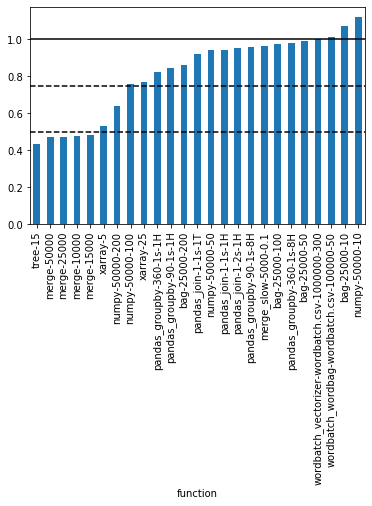

In [61]:
compute_r(df[df.nodes == 1], df.runtime == "dask").plot.bar()
plt.axhline(y=1.0, color='black', linestyle='-')
plt.axhline(y=0.75, color='black', linestyle='--')
plt.axhline(y=0.5, color='black', linestyle='--')
plt.savefig("ws1.png")

In [1]:
def create_plot(frame, plot_fn):
    def extract(fn):
        sortkey = []
        for item in fn.split("-"):
            try:
                num = float(item)
                sortkey.append(num)
            except:
                pass
        return tuple(sortkey)
    
    
    def cluster_key(name):        
        t = name.split("-")
        for x in t:
            if x and x[0].isdigit():
                break        
        key = [int(x[:-1])] + t
        print(key)
        return key
    
    clusters = sorted(set(frame["cname"]), key=cluster_key)
    functions = sorted(frame["benchmark"].unique(), key=extract)

    def plot(data, **kwargs):
        plot_fn(data, clusters, **kwargs)

    g = sns.FacetGrid(frame, col="benchmark", col_wrap=4, col_order=functions, sharey=False)
    g = g.map_dataframe(plot)
    g = g.add_legend()
    g.set_ylabels("Time [s]")
    g.set(ylim=(0, None))
    g.set_xticklabels(rotation=90)
    return g

def plot_scatter(data, clusters, **kwargs):
    y = data["time"]
    sns.swarmplot(x=data["cname"], y=y, hue=data["cname"], order=clusters, hue_order=clusters)

#selection = df[df.function.isin(["xarray-5", "tree-15", "pandas_groupby-90-1s-8H", "numpy-50000-10"])]
selection = df
create_plot(selection, plot_scatter)
plt.show()
plt.savefig('swarm1.pdf', bbox_inches='tight')
#create_plot(df[df.function.isin(["xarray-5", "tree-15", "numpy-50000-10"])], plot_scatter)

NameError: name 'df' is not defined